# Allocation dynamique des ressources dans le cloud

## 1. Importation des librairies et définition des constantes

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Définition des constantes
K = 5  # nombre maximal de VMs
B = 15  # capacité du système
d = 5  # nombre de paquets servis par slot
b = 10  # taille maximale du batch
C_f = 1  # coût d'une VM en fonctionnement par slot
C_a = 10  # coût d'activation d'une VM
C_d = 3  # coût de désactivation d'une VM
C_H = 2  # coût de maintien d'un client dans la file

num_states = int((B + 1) * (K + 1))
num_actions = K + 1

## 2. Modélisation du problème
On a K le nombre maximal de VMs donc le nombre de serveurs actifs $n \in \{0,1,\ldots,K\}$. 

On a B la capacité maximale du système donc le nombre de clients dans le système $m \in \{0,1,\ldots,B\}$

Pour la modélisation du problème on a codé les états $s=(m,n)$ en une seule dimension telle que $s = m+n(B+1)$. On a donc $s \in \{0,1,\ldots,(B+1)\times(K+1)-1\}$.


La matrice de transition $P$ est une donc une matrice de dimensions $nombre\space d'états\times nombre\space d'actions \times nombre\space d'états$ : la première dimension correspond à l'état actuel, la deuxième à l'action et la troisième à l'état suivant.

On a donc $P_{s,\alpha,s'}$ la probabilité de passer de l'état $s$ à l'état $s'$ en effectuant l'action $\alpha$.

En parcourant chaque dimension il est possible de calculer la probabilité de passer d'un état à un autre en effectuant une action en suivant l'énoncé du problème. On calcule ainsi la matrice de probabilité de transition $P$. On calcule de même la matrice de récompense $R$. Ici, comme on cherche à minimiser le coût, on renvoie donc le coût négatif en tant que récompense, pour par la suite maximiser la récompense.


In [16]:
def build_MDP(P_A, K = K, B = B, d = d, b = b, C_f = C_f, C_a = C_a, C_d = C_d, C_H = C_H):
    # Initialisation des matrices
    num_states = int((B + 1) * (K + 1))
    num_actions = K + 1

    P = np.zeros((num_states, num_actions, num_states))
    R = np.zeros((num_states, num_actions))

    # Remplissage des matrices P et R
    # On parcourt tous les états possibles
    for m in range(B+1):
        for n in range(K+1):
            # On parcourt toutes les actions possibles
            for j in range(K+1):
                s = m + n * (B + 1)
                R[s,j] = j * C_f + max(0, j - n) * C_a + max(0, n - j) * C_d + m * C_H
                # On parcourt toutes les arrivées possibles
                for i in range(b+1):
                    m_ = min(B, max(0, m + i - j * d))
                    n_ = j
                    s_ = m_ + n_ * (B + 1)
                    if i>= len(P_A):
                        P[s,j,s_] += 0
                    else:
                        P[s,j,s_] += P_A[i]
    return P, -R

On définit deux probabilités d'arrivée de clients $P_{A1}$ et $P_{A2}$, l'une centrée sur plutôt centrée sur 4 et l'autre uniforme. On construit ainsi deux matrices de probabilité de transition $P_1$ et $P_2$ et deux matrices de récompense $R_1$ et $R_2$.

In [17]:
# Probabilités d'arrivée des paquets
P_A1 = [0.1, 0.2, 0.1, 0.6]
P_A2 = [0.2, 0.2, 0.2, 0.2, 0.2]


P1, R1 = build_MDP(P_A1)
P2, R2 = build_MDP(P_A2)

## 3. Q-value iteration
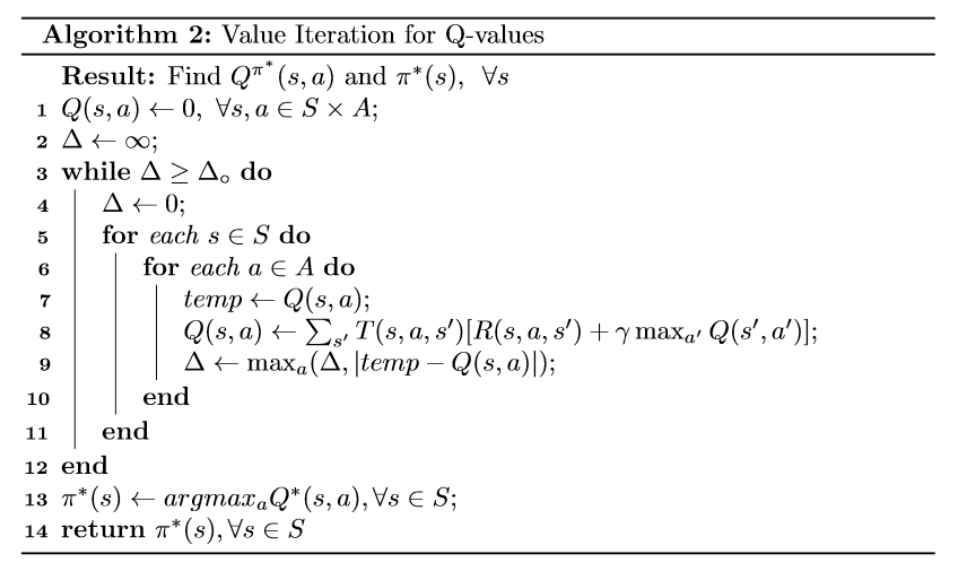

Pour maximiser la Q-value on utilise l'algorithme de Q-value iteration. On cherche donc à maximiser la fonction $Q(s,\alpha) = R(s,\alpha) + \gamma \sum_{s'} P_{s,\alpha,s'} Q(s',\alpha')$ où $\gamma$ est le facteur d'actualisation.

In [18]:
def q_value_iteration(P, R, gamma, epsilon=0.001, K = K, B = B, max_iterations = 1000):
    num_states = int((B + 1) * (K + 1))
    num_actions = K + 1

    # Initialisation de la matrice Q
    Q = -100 * np.ones((num_states, num_actions))
    
    # On itère jusqu'à convergence ou jusqu'à un nombre maximal d'itérations
    for i in range(max_iterations):
        Q_prev = np.copy(Q)
        for s in range(num_states):
            for a in range(num_actions):
                Q[s][a] = np.sum(P[s][a] * (R[s][a] + gamma * np.max(Q_prev, axis=1)))
        if np.abs(Q - Q_prev).max() < epsilon:
            break
    return Q

## 4. Q-learning

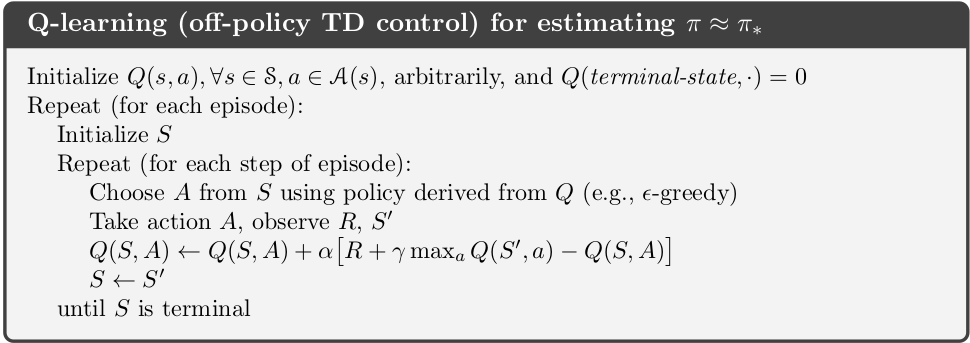

L'algorithme de Q-learning est une méthode d'apprentissage par renforcement. Il permet de trouver une politique optimale en fonction d'une fonction de récompense. À chaque épisode, l'algorithme choisit un état. Puis à chaque étape, une action est choisie de manière aléatoire avec une probabilité $\epsilon$ ou de manière optimale avec une probabilité $1-\epsilon$. L'état suivant est choisit grâce à la répartition de probabilité de l'état actuel en fonction de l'action. L'algorithme met ensuite à jour la Q-value de l'état et de l'action choisie en fonction de la récompense obtenue et de la Q-value maximale de l'état suivant : $Q(s,\alpha) \leftarrow (1-\alpha)Q(s,\alpha) + \alpha(R(s,\alpha) + \gamma \max_{\alpha'} Q(s',\alpha'))$.
On répète ce processus jusqu'à un nombre d'étapes et d'épisodes maximum.

In [19]:
def q_learning(P, R, num_episodes, num_steps, alpha= 0.1, gamma= 0.9, epsilon = 0.1, K = K, B = B):
    num_states = int((B + 1) * (K + 1))
    num_actions = K + 1

    # Initialisation de la matrice Q
    Q = -100 * np.ones((num_states, num_actions))
    q_learning_list = []

    # Repeat until convergence or maximum number of iterations
    for episode in range(num_episodes):
        # Choose a random state
        state = np.random.randint(num_states)
        
        # Repeat until the episode ends
        for step in range(num_steps):
            # Choose an action based on the current Q-value table and epsilon-greedy policy
            if np.random.rand() < epsilon:   
                action = np.random.choice(num_actions, p=Q[state]/np.sum(Q[state]))
            else:
                action = np.argmax(Q[state])
            
            # Get the next state and reward based on the current state and action
            next_state = np.random.choice(num_states, p=P[state, action])

            # Update the Q-value table
            Q[state, action] += alpha * (R[state, action] + gamma * np.max(Q[next_state]) - Q[state, action])

            # Update the current state
            state = next_state

        # Store the maximum Q-value for each episode
        q_learning_list.append(np.max(Q))
        
    return Q, q_learning_list

## 5. SARSA
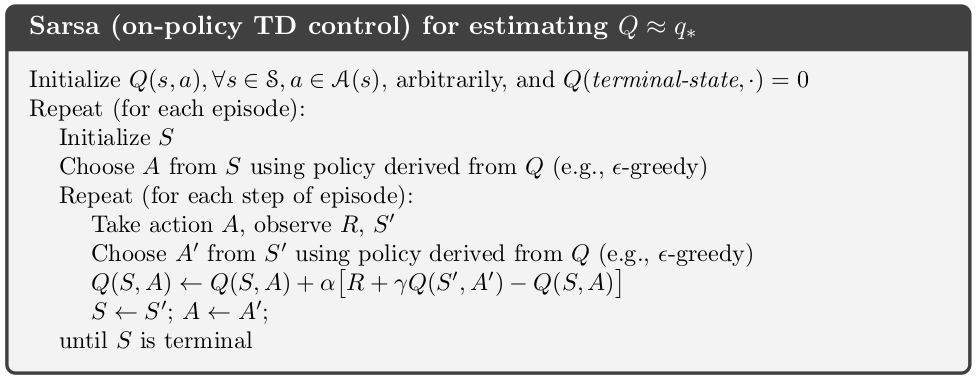

Tout comme l'algorithme de Q-learning, l'algorithme SARSA est une méthode d'apprentissage par renforcement. Il permet de trouver une politique optimale en fonction d'une fonction de récompense. À chaque épisode, l'algorithme choisit un état et une action est choisie de manière aléatoire avec une probabilité $\epsilon$ ou de manière optimale avec une probabilité $1-\epsilon$. L'état suivant est choisit grâce à la répartition de probabilité de l'état actuel en fonction de l'action puis l'action suivante est choisie de manière aléatoire avec une probabilité $\epsilon$ ou de manière optimale avec une probabilité $1-\epsilon$. L'algorithme met ensuite à jour la Q-value de l'état et de l'action choisie en fonction de la récompense obtenue et de la Q-value de l'état et de l'action suivants : $Q(s,\alpha) \leftarrow (1-\alpha)Q(s,\alpha) + \alpha(R(s,\alpha) + \gamma Q(s',\alpha'))$.

In [20]:
def sarsa(P, R, num_episodes, num_steps, alpha= 0.1, gamma= 0.9, epsilon = 0.1, K = K, B = B):
    num_states = int((B + 1) * (K + 1))
    num_actions = K + 1

    # Initialize Q-value table
    Q = -100 * np.ones((num_states, num_actions))
    SARSA_list = []

    # Repeat until convergence or maximum number of iterations
    for i in range(num_episodes):
        # Choose a random state
        state = np.random.randint(num_states)
        
        # Choose an action based on the current Q-value table and epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.choice(num_actions, p=Q[state]/np.sum(Q[state]))
        else:
            action = np.argmax(Q[state])

        # Repeat for num_steps
        for step in range(num_steps):
            # Get the next state based on the current state and action
            next_state = np.random.choice(num_states, p=P[state, action])
            # Choose an action based on the current Q-value table and epsilon-greedy policy
            if np.random.rand() < epsilon:
                next_action = np.random.choice(num_actions, p=Q[next_state]/np.sum(Q[next_state]))
            else:
                next_action = np.argmax(Q[next_state])   

            # Update the Q-value table
            Q[state, action] += alpha * (R[state, action] + gamma * Q[next_state, next_action] - Q[state, action])

            # Update the current state and action
            state = next_state
            action = next_action

        # Store the maximum Q-value for each episode
        SARSA_list.append(np.max(Q))
        
    return Q, SARSA_list

## 6. Comparaison des deux algorithmes et conclusion

Pour chacune des répartitions de probabilité d'arrivée, on a fait varier les hyperparamètres $\gamma$ et $\alpha$ pour pouvoir comparer leur efficacité sur la rapidité et la stabilité de la convergence. On a pris $\gamma \in \{0.1,0.5,0.9\}$ et $\alpha \in \{0.1,0.5,0.9\}$. Le nombre d'épisodes est fixé à 2000 et le nombre d'itérations par épisode à 500.

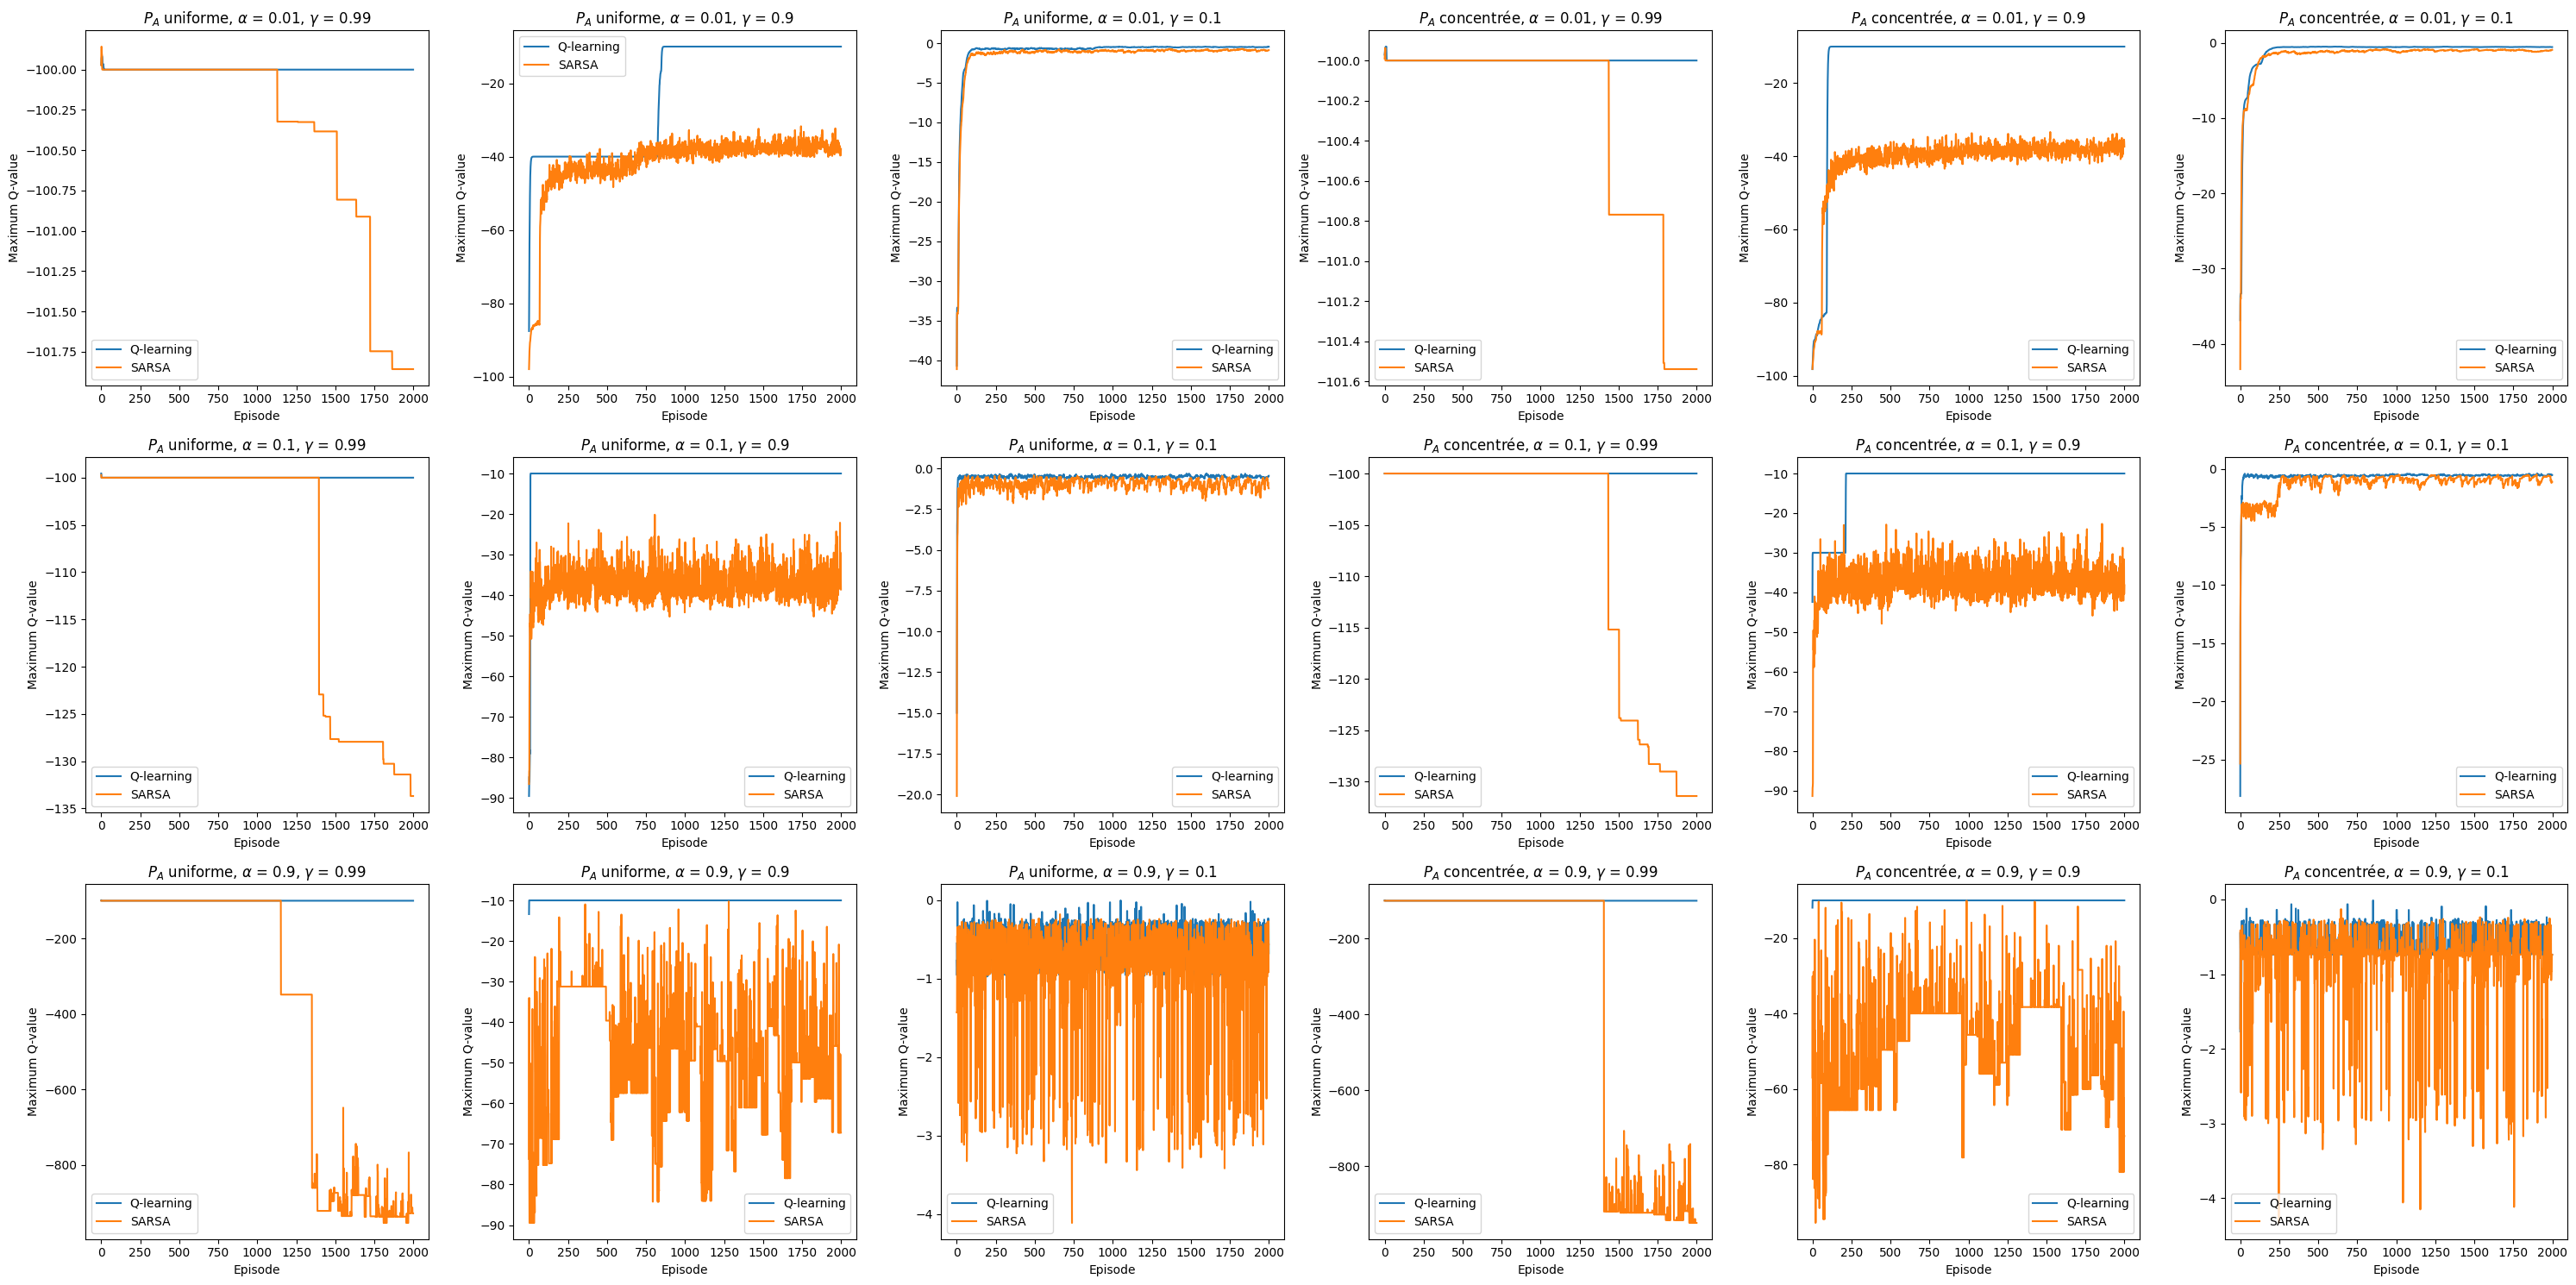

In [21]:
# Vary the parameters of learning algorithms
alpha_list = [0.01, 0.1, 0.9]
gamma_list = [0.99, 0.9, 0.1]
num_episodes = 2000
num_steps = 500

# Plot the learning curves for Q-learning and SARSA for different values of P_A and alpha and gamma in 18 subplots
fig, ax = plt.subplots(len(alpha_list), 2 * len(gamma_list), figsize=(30, 15))
for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    for j in range(len(gamma_list)):
        gamma = gamma_list[j]
        Q1_q_learning, q_learning_list = q_learning(P1, R1, num_episodes, num_steps, alpha = alpha, gamma = gamma)
        Q1_SARSA, SARSA_list = sarsa(P1, R1, num_episodes, num_steps, alpha = alpha, gamma = gamma)
        Q_2_q_learning, q_learning_list_2 = q_learning(P2, R2, num_episodes, num_steps, alpha = alpha, gamma = gamma)
        Q_2_SARSA, SARSA_list_2 = sarsa(P2, R2, num_episodes, num_steps, alpha = alpha, gamma = gamma)
        ax[i, j].plot(q_learning_list_2, label='Q-learning')
        ax[i, j].plot(SARSA_list_2, label='SARSA')
        ax[i, j].set_xlabel('Episode')
        ax[i, j].set_ylabel('Maximum Q-value')
        ax[i, j].set_title(r'$P_A$ uniforme, $\alpha$ = {}, $\gamma$ = {}'.format(alpha, gamma))
        ax[i, j+3].plot(q_learning_list, label='Q-learning')
        ax[i, j+3].plot(SARSA_list, label='SARSA')
        ax[i, j+3].set_xlabel('Episode')
        ax[i, j+3].set_ylabel('Maximum Q-value')
        ax[i, j+3].set_title(r'$P_A$ concentrée, $\alpha$ = {}, $\gamma$ = {}'.format(alpha, gamma))
        ax[i, j].legend()
        ax[i, j+3].legend()
plt.tight_layout()

À l'aide des graphiques ci-dessus, on peut observer l'impact de la variation des hyperparamètres $\gamma$ et $\alpha$ sur la convergence des deux algorithmes. On peut voir que pour les deux algorithmes, la convergence est plus rapide lorsque $\gamma$ est proche de 1 et que $\alpha$ est proche de 0. Cependant, une valeur de gamma trop élevée peut entraîner des problèmes de convergence, comme on peut le voir pour $\gamma = 0.99$. Pour des valeurs de $\alpha$ trop élevées, on peut observer que la convergence est instable : il y a énormément d'oscillations pour l'algorithme SARSA. Pour les deux algorithmes, la convergence est plus rapide et plus stable lorsque $\gamma$ est proche de 0. Cela signifie que l'algorithme privilégie les récompenses immédiates plutôt que les récompenses futures. En itérant sur plus d'épisodes et d'étapes, on pourrait peut-être observer une valeur limite de coût plus faible pour un $\gamma$ plus élevé et donc éviter les comportements suboptimaux.

Observons maintenant l'impact de la valeur $\epsilon$ sur la convergence des deux algorithmes. On a pris $\epsilon \in \{0.01, 0.1, 0.5\}$ et on a fixé $\gamma = 0.9$ et $\alpha = 0.1$.

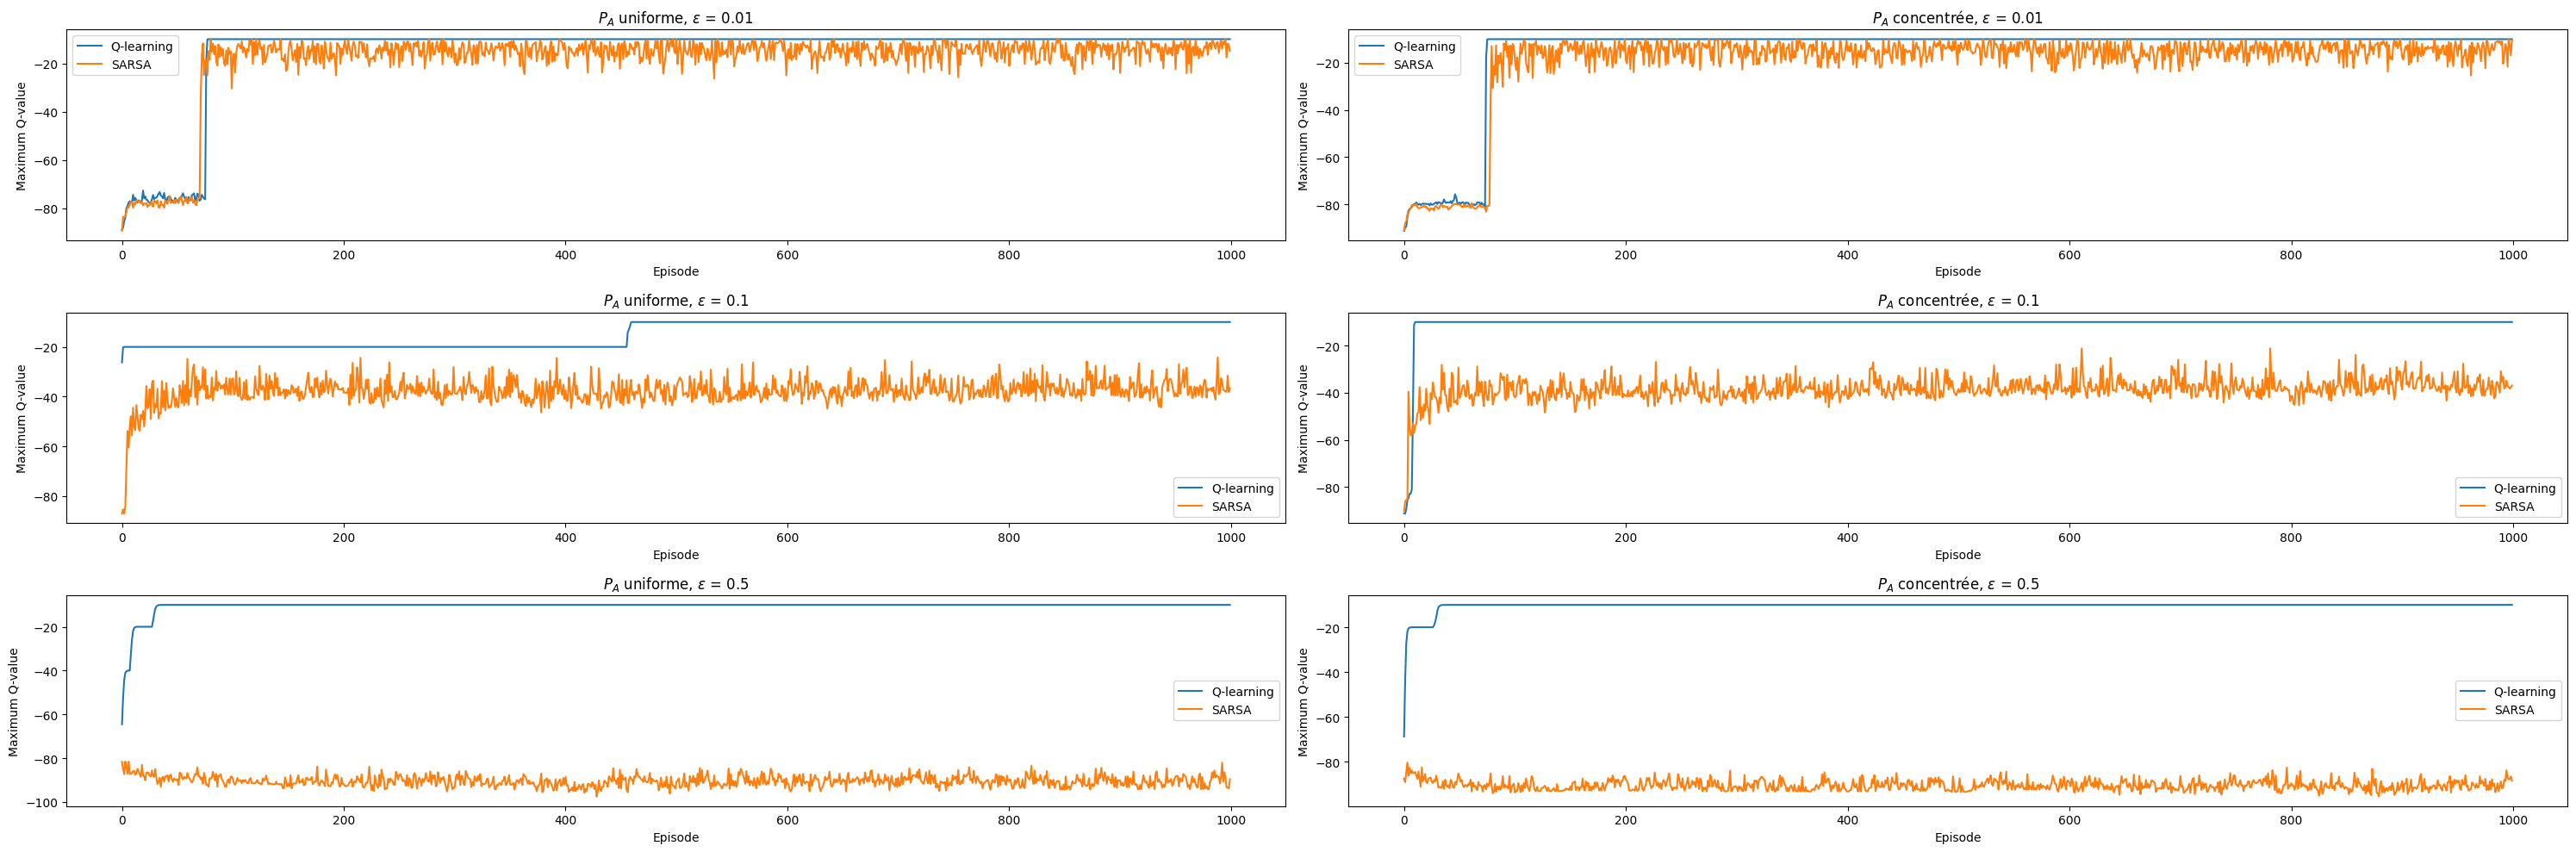

In [22]:
epsilon_list = [0.01, 0.1, 0.5]
gamma = 0.9
alpha = 0.1
num_episodes = 1000
num_steps = 500

# Plot the learning curves for Q-learning and SARSA for different values of epsilon in 6 subplots
fig, ax = plt.subplots(len(epsilon_list), 2, figsize=(30, 10))
for i in range(len(epsilon_list)):
    epsilon = epsilon_list[i]
    Q1_q_learning, q_learning_list = q_learning(P1, R1, num_episodes, num_steps, alpha = alpha, gamma = gamma, epsilon = epsilon)
    Q1_SARSA, SARSA_list = sarsa(P1, R1, num_episodes, num_steps, alpha = alpha, gamma = gamma, epsilon = epsilon)
    Q_2_q_learning, q_learning_list_2 = q_learning(P2, R2, num_episodes, num_steps, alpha = alpha, gamma = gamma, epsilon = epsilon)
    Q_2_SARSA, SARSA_list_2 = sarsa(P2, R2, num_episodes, num_steps, alpha = alpha, gamma = gamma, epsilon = epsilon)
    ax[i,0].plot(q_learning_list_2, label='Q-learning')
    ax[i,0].plot(SARSA_list_2, label='SARSA')
    ax[i,0].set_xlabel('Episode')
    ax[i,0].set_ylabel('Maximum Q-value')
    ax[i,0].set_title(r'$P_A$ uniforme, $\epsilon$ = {}'.format(epsilon))
    ax[i,1].plot(q_learning_list, label='Q-learning')
    ax[i,1].plot(SARSA_list, label='SARSA')
    ax[i,1].set_xlabel('Episode')
    ax[i,1].set_ylabel('Maximum Q-value')
    ax[i,1].set_title(r'$P_A$ concentrée, $\epsilon$ = {}'.format(epsilon))
    ax[i,0].legend()
    ax[i,1].legend()
plt.tight_layout()


$\epsilon$ influe sur la rapidité de convergence des deux algorithmes et en particulier l'algorithme SARSA. En effet, dans l'algorithme SARSA, l'action suivante est choisie de manière aléatoire avec une probabilité $\epsilon$ ou de manière optimale avec une probabilité $1-\epsilon$, là où dans l'algorithme de Q-learning, l'action suivante est choisie de manière optimale. On peut donc observer que lorsque $\epsilon$ est proche de 0, l'algorithme SARSA se rapproche de l'algorithme de Q-learning.